In [ ]:
import matplotlib.pyplot as plt
from typing import Callable, List
import numpy as np
import itertools
import functools

In [64]:
# the state of N qubits is a complex vector of dimension 2^N
n_qubits = 2
dimension = 2**n_qubits

def print_probs(state, n_qubits):
    # the elements of this state are squared to calculate outcome probabilities
    for bitstring in range(2**n_qubits):
        probability = np.abs(state[bitstring]) ** 2
        print("Bitstring", format(bitstring, "0" + str(n_qubits) + "b"), \
            " has probability ", probability)
    print()

# as a first example, the i|0> state
state = [1j, 0, 0, 0]
print_probs(state, n_qubits)
# an example with a "superposition" over outcomes
print_probs([0, -1j / np.sqrt(2), 0, 1 / np.sqrt(2)], n_qubits)

# evolution is then given by a unitary matrix
identity = np.array([[1, 0], [0, 1]]) # identity on one qubit
flip = np.array([[0, 1], [1, 0]]) # a flip or X-gate on one qubits, like the (classical) NOT gate

# tensor products make this a two qubit operation
flip_first = np.kron(flip, identity) # flip the first qubit, leave second qubit alone
new_state = flip_first @ state
print_probs(new_state, n_qubits)

flip_second = np.kron(identity, flip)
new_state = flip_second @ state
print_probs(new_state, n_qubits)

# if we start in the state with all qubits in zero
# then we can take a shortcut to get the probabilities of any particular bitstring
all_zeros = [1] + [0]*(dimension-1)
bs = np.random.choice(range(dimension))
assert (flip_second @ all_zeros)[bs] == flip_second[bs, 0]

#print(flip_second[bs, 0], bs)
print(flip_first)
print(flip_second)

Bitstring 00  has probability  1.0
Bitstring 01  has probability  0
Bitstring 10  has probability  0
Bitstring 11  has probability  0

Bitstring 00  has probability  0
Bitstring 01  has probability  0.4999999999999999
Bitstring 10  has probability  0
Bitstring 11  has probability  0.4999999999999999

Bitstring 00  has probability  0.0
Bitstring 01  has probability  0.0
Bitstring 10  has probability  1.0
Bitstring 11  has probability  0.0

Bitstring 00  has probability  0.0
Bitstring 01  has probability  1.0
Bitstring 10  has probability  0.0
Bitstring 11  has probability  0.0

[[0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]]
[[0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]]


In [ ]:
def random_unitary(dim: int) -> np.ndarray:
  # follows the algorithm in https://arxiv.org/pdf/math-ph/0609050.pdf
  # returns a unitary of size dim x dim
  Z = np.array([np.random.normal(0, 1) + np.random.normal(0, 1) * 1j for _ in range(dim ** 2)]).reshape(dim, dim)
  Q, R = np.linalg.qr(Z)
  diag = np.diagonal(R)
  lamb = np.diag(diag) / np.absolute(diag)
  unitary = np.matmul(Q, lamb)

  # this condition asserts that the matrix is unitary
  assert np.allclose(unitary.conj().T @ unitary, np.eye(dim))

  return unitary

# unitary property check
U = random_unitary(2)
V = U.T.conj()
print('U = ', U)
print('Product = ', np.matmul(U, V))

U =  [[0.04002098+0.77084642j 0.25718394-0.58142113j]
 [0.5592145 -0.30244547j 0.77159387-0.02118455j]]
Product =  [[ 1.00000000e+00+0.00000000e+00j -2.77555756e-17+3.26128013e-16j]
 [-2.77555756e-17-3.26128013e-16j  1.00000000e+00+0.00000000e+00j]]


In [ ]:
def simulate_probability(unitary: np.ndarray, bitstring:int) -> float:
  # simulates the probability of measuring bitstring when evolving from the ground state
  # according to the quantum program given unitary
  return np.abs(unitary[bitstring, 0])**2


def quantum_sample_probability(n_qubits: int, trials: int) -> List:
  # returns the probabilities of a randomly chosen bistring outcome over "trials" number of different
  # random quantum programs on n_qubits

  dimension = 2**n_qubits
  # picks a random bitstring as labelled by the integers 1 to 2**n_qubits
  bitstring = np.random.choice(dimension)

  # keeps track of the probability of sampling the (randomly) chosen bitstring
  probs_bitstring = []
  # simulate the execution of many Haar-random quantum programs
  for _ in range(trials):
      unitary = random_unitary(dimension)
      prob = simulate_probability(unitary, bitstring)
      probs_bitstring.append(prob)

  return probs_bitstring

unitary = random_unitary(dimension)
bitstring = np.random.choice(dimension)
bs_prob = simulate_probability(unitary, bitstring)
print('unitary = ', unitary)
print('bitstring = ', bitstring)
print('bs_prob = ', bs_prob)

unitary =  [[ 0.43477754+0.10575743j  0.10118048-0.8335004j  -0.18198301+0.06317228j
  -0.20344163+0.12777475j]
 [ 0.01793313-0.24873537j  0.08079142+0.07459664j -0.68077841+0.48406382j
   0.1112605 -0.46428578j]
 [ 0.38505521+0.19501055j -0.34621226+0.16786213j  0.07038375-0.26359416j
  -0.46503988-0.61234378j]
 [-0.7135926 -0.20513886j -0.12780611-0.34434379j -0.21160264-0.3819725j
  -0.31317018-0.15824782j]]
bitstring =  0
bs_prob =  0.20021614672804314


speckle =  [0.02853294481711003, 0.08458236604802156, 0.08243978031395503, 0.19200125196159454, 0.04666463447868778, 0.13552678493653636, 0.07659310501899938, 0.002510864024651467, 0.06856891960275761, 0.007878503724550007, 0.0022489468023839027, 0.035457092711014875, 0.12654307235055084, 0.05267933330477642, 0.017188980195451297, 0.040583419708958415]
total =  0.9999999999999996


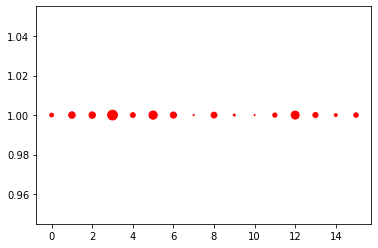

In [14]:
n_qubits = 4
dimension = 2**n_qubits
def speckle(n_qubits: int):
  dimension = 2**n_qubits
  unitary = random_unitary(dimension)
  # initiate probabilities
  probs_bitstring = []
  for bitstring in range(dimension):
    # simulate the execution a random quantum circuit
    prob = simulate_probability(unitary, bitstring)
    probs_bitstring.append(prob)
#  return probs_bitstring

  return probs_bitstring

speckle = speckle(n_qubits)
print('speckle = ', speckle)
# check total probability = 1
print('total = ', sum(speckle) )
x_axis = range(dimension)
y_axis = np.ones(dimension)
plt.scatter(x_axis, y_axis, s=np.multiply(500, speckle), color = 'r')

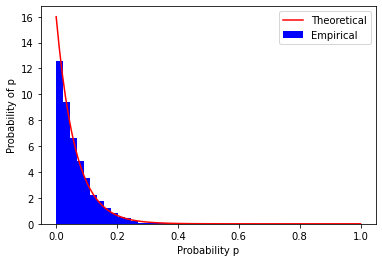

In [18]:
n_qubits = 4
porter_thomas = quantum_sample_probability(n_qubits, 10_000)

# theoretical distribution
dim = 2**n_qubits
xspace = np.linspace(0.0, 1.0, 100)
yspace = dim * np.exp(-dim*xspace)

# compare empirical and theoretical distributions
plt.figure(figsize=(6, 4))
plt.hist(porter_thomas, bins=20, density=True, label='Empirical', color='b')
plt.plot(xspace, yspace, label='Theoretical', color='r')

plt.xlabel("Probability p")
plt.ylabel("Probability of p")
plt.legend(loc='best')
plt.show()